In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


In [4]:
warnings.filterwarnings("ignore")
import yaml
import os

# pd.set_option('display.max_columns', 40)
# pd.set_option('display.max_colwidth', 300)
from sklearn.metrics import (precision_score,recall_score,
                             f1_score, accuracy_score,confusion_matrix, classification_report)

In [29]:
colorcode=pd.read_csv('../data/processed/color_code.csv',index_col=0)
train=pd.read_csv('../data/train/train.csv',index_col=0)
test=pd.read_csv('../data/test/test.csv',index_col=0)

In [4]:
train.groupby('Simple_style')['IBU'].describe()

,count,mean,std,min,25%,50%,75%,max
Simple_style,,,,,,,,
Brown Ale,1136.0,34.960933,19.844097,1.72,24.4900,30.095,39.2175,246.16
Pale Ale,18450.0,54.874818,21.565882,30.00,35.3500,49.465,71.8200,100.00
Pale Lager/Blonde Ale,4018.0,23.351458,5.444155,8.00,19.6800,25.625,28.0000,28.00
Stout/Porter,4898.0,46.000349,20.119155,18.00,31.0625,39.995,57.8250,90.00
Strong Ale,1782.0,44.610802,25.139218,20.00,25.3800,34.465,57.3075,100.00
Wheat,2587.0,17.877464,7.345762,0.40,12.7500,16.690,23.1450,30.00


In [30]:
X_train=train[['ABV','IBU','Color']]
X_test=test[['ABV','IBU','Color']]

y_train=train['Style_color']
y_test=test['Style_color']

Text(0.5, 0, 'Style')

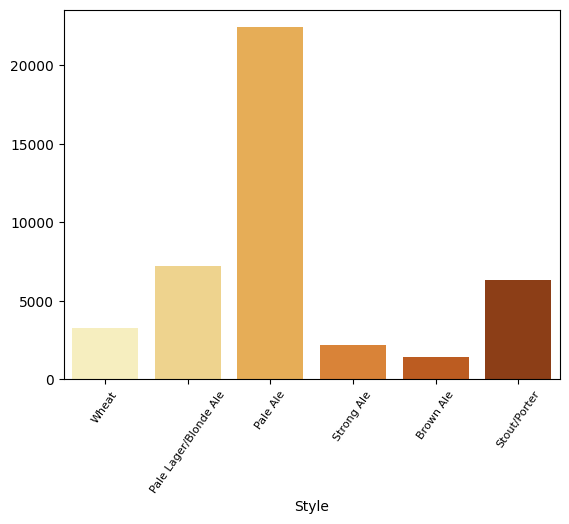

In [31]:
traincounts=y_train.value_counts()
sns.barplot(x=traincounts.index, y=traincounts.values, palette="YlOrBr")
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.xlabel('Style')

First we use RandomUnderSampler to balance the classes

In [32]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [33]:
y_resampled.value_counts()

Style_color
0    1402
1    1402
2    1402
3    1402
4    1402
5    1402
Name: count, dtype: int64

In order to scale the data, we use ColumnTransformer, since we do not want to scale all of the columns, but just three of them.

In [35]:
from sklearn.compose import ColumnTransformer
col_toscale=['ABV', 'IBU', 'Color']
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), col_toscale)],
    remainder='passthrough')

Building a pipeline to determine the best features and classifier with a grid search:

In [36]:
pipeScale = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ("selectkbest", SelectKBest(k=3)),
    ("classifier", RandomForestClassifier())
])

In [46]:
log_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [LogisticRegression()],
    'classifier__C': [0.1,1,10]
}
rf_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [3,5,7]
}
gb_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [GradientBoostingClassifier()],
    'classifier__max_depth':[3]
}
knn_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': np.arange(1,10)
}
svm_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10]
}

search_space = [
    # {'preprocessor__scaler__feature_range': [(0, 1)]},   #remove for gs2
    log_params,
    rf_params,
    gb_params,
    knn_params,
    svm_params   
]

In [39]:

scoring={'f1_weighted': 'f1_weighted',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted'}
clf_gs = GridSearchCV(estimator=pipeScale, param_grid=search_space, cv=5, scoring=scoring, refit='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')

In [40]:
clf_gs.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 58 candidates, totalling 290 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         ['ABV',
                                                                          'IBU',
                                                                          'Color'])])),
                                       ('selectkbest', SelectKBest(k=3)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'preprocessor__scaler__feature_range': [(0, 1)]},
                         {'classifier': [Log...
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'selectkbest__k': array([1, 2, 3])},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'selectkbest__k': array([1, 2, 3])}],
             refit='f1_weighted',
             scoring={'f1_weighted': 'f1_weighted',
                      'precision_weighted': 'precision_weighted',
                      'recall_weighted': 'recall_weighted'},
             verbose=3)

In [42]:
print(clf_gs.best_estimator_)
print(clf_gs.best_score_)
print(clf_gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['ABV', 'IBU', 'Color'])])),
                ('selectkbest', SelectKBest(k=3)),
                ('classifier', GradientBoostingClassifier())])
0.8611131903320995
{'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 3, 'selectkbest__k': 3}


In [43]:
y_pred = clf_gs.best_estimator_.predict(X_test)

print('accuracy_score',accuracy_score(y_pred,y_test))
print('precision_score',precision_score(y_pred,y_test, average='weighted'))
print('f1_score',f1_score(y_pred,y_test, average='weighted'))
print('recall_score',recall_score(y_pred,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.9044014578076816
precision_score 0.9016898840555758
f1_score 0.8995516666730349
recall_score 0.9044014578076816


## Best model:
Let's try one more time without scaling the data (Spoiler: this was the best option)

In [47]:
pipeNoscale = Pipeline(steps=[
    ("selectkbest", SelectKBest(k=3)),
    ("classifier", RandomForestClassifier())
])
clf_gs2 = GridSearchCV(estimator=pipeNoscale, param_grid=search_space, cv=5, scoring=scoring, refit='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')

In [49]:
clf_gs2.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 57 candidates, totalling 285 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('selectkbest', SelectKBest(k=3)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10],
                          'selectkbest__k': array([1, 2, 3])},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [3, 5, 7],
                          'selectkbest__k': ar...
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'selectkbest__k': array([1, 2, 3])},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'selectkbest__k': array([1, 2, 3])}],
             refit='f1_weighted',
             scoring={'f1_weighted': 'f1_weighted',
                      'precision_weighted': 'precision_weighted',
                      'recall_weighted': 'recall_weighted'},
             verbose=3)

In [50]:
print(clf_gs2.best_estimator_)
print(clf_gs2.best_score_)
print(clf_gs2.best_params_)

Pipeline(steps=[('selectkbest', SelectKBest(k=3)),
                ('classifier', GradientBoostingClassifier())])
0.8607641385000118
{'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 3, 'selectkbest__k': 3}


In [16]:
# gbc_noscale_params=clf_gs2.best_params_

Let's make some predictions and evaluate our model.

In [51]:
# scaled_GBC=clf_gs.best_estimator_
GBC2=clf_gs2.best_estimator_

In [ ]:
# feature_importances = GBC2.feature_importances_

In [52]:
gbc_noscale=GBC2.fit(X_resampled,y_resampled)

In [53]:
# y_predScale = clf_gs.best_estimator_.predict(X_test)
y_pred2 = GBC2.predict(X_test)

In [20]:
predictions_proba = GBC2.predict_proba(X_test)
# predictions_proba

Text(0, 0.5, 'Log-Transformed Probability')

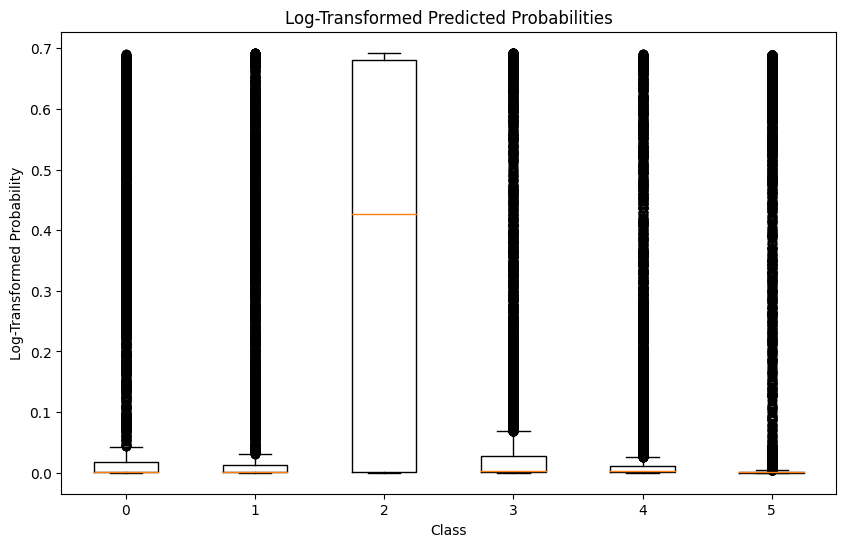

In [27]:
log_proba_values = np.log1p(predictions_proba)
plt.figure(figsize=(10, 6))
plt.boxplot(log_proba_values, labels=GBC2.classes_)
plt.title('Log-Transformed Predicted Probabilities')
plt.xlabel('Class')
plt.ylabel('Log-Transformed Probability')

In [54]:

print('accuracy_score',accuracy_score(y_pred2,y_test))
print('precision_score',precision_score(y_pred2,y_test, average='weighted'))
print('f1_score',f1_score(y_pred2,y_test, average='weighted'))
print('recall_score',recall_score(y_pred2,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.9045416316232128
precision_score 0.9018227113729609
f1_score 0.8997318627701234
recall_score 0.9045416316232128


In [21]:
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'final_model_config.yaml'), 'w') as file:
    yaml.dump(gbc_noscale_params, file, default_flow_style=False)

In [110]:
cm = confusion_matrix(y_test, y_pred2,normalize='true')
# print(cm)

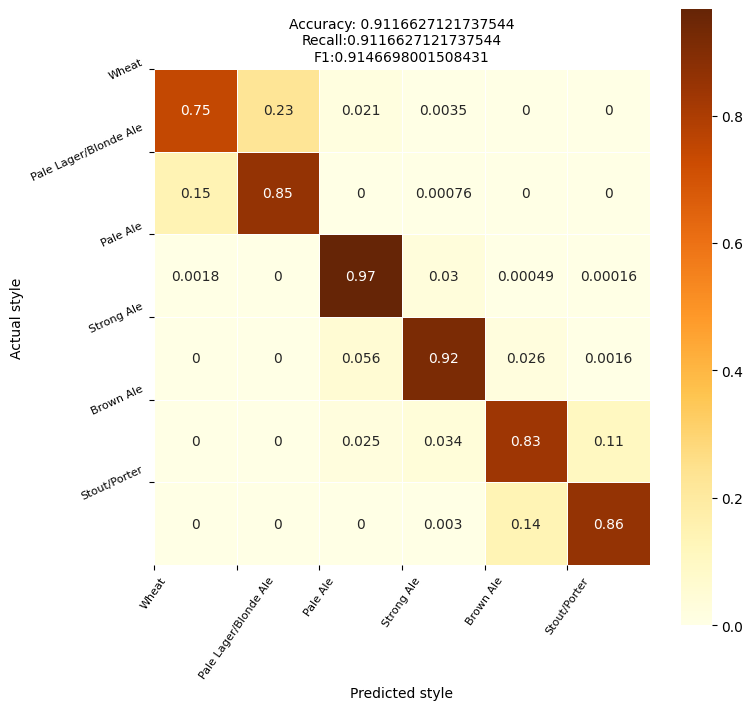

In [111]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_pred2)}\nRecall:{recall_score(y_test, y_pred2, average="weighted")}\nF1:{f1_score(y_test, y_pred2, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

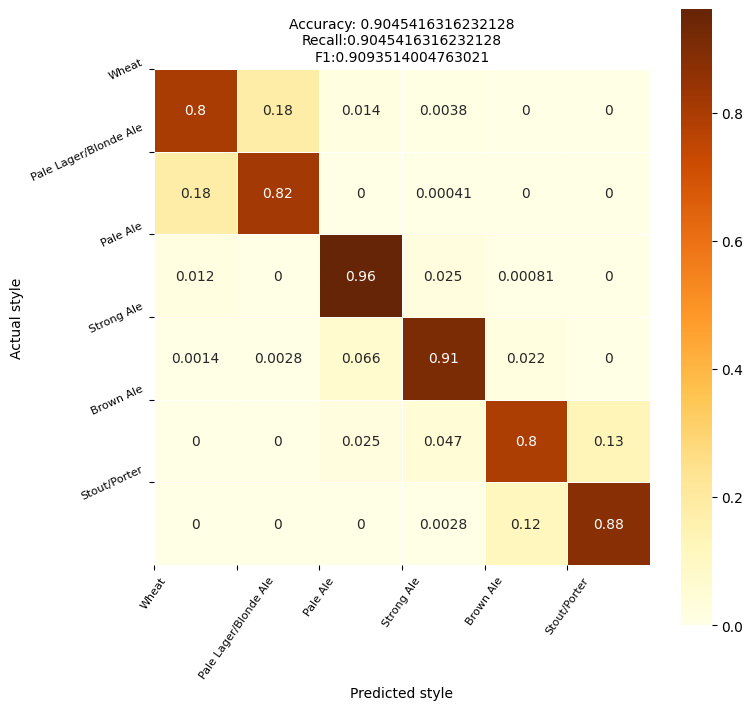

In [55]:
# #new
# cm = confusion_matrix(y_test, y_pred2,normalize='true')
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
# plt.ylabel('Actual style')
# plt.xlabel('Predicted style')
# all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_pred2)}\nRecall:{recall_score(y_test, y_pred2, average="weighted")}\nF1:{f1_score(y_test, y_pred2, average="weighted")}')
# plt.title(all_sample_title, size = 10);
# plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
# plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [13]:
testcounts=y_test.value_counts()

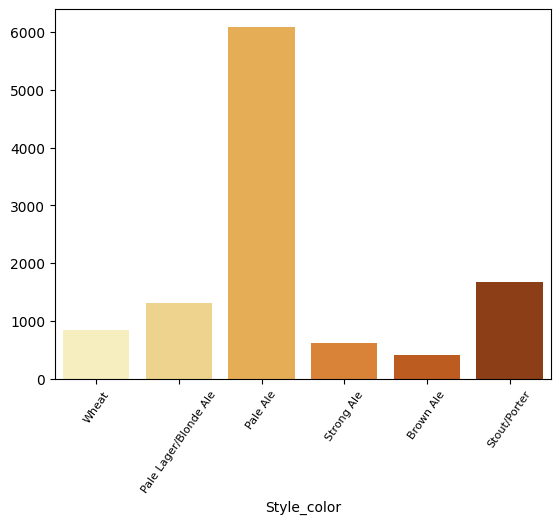

In [15]:
sns.barplot(x=testcounts.index, y=testcounts.values, palette="YlOrBr")
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);

In [20]:
import pickle
with open('../models/final_model_gbc.pkl', 'wb') as output:
    pickle.dump(gbc_noscale, output)

# with open('../models/trained_model_gbc_noscaling.pkl', 'rb') as input:
#     modelo_importado = pickle.load(input) 

## Trying unsupervised learning: Clustering (KMeans)

In [9]:
km_list = [KMeans(n_clusters=k, n_init=10, random_state=0).fit(X_resampled) for k in range(2,20)]
# km_list

In [10]:
silhouette_score_list = [silhouette_score(X_resampled, model.labels_) for model in km_list]
# silhouette_score_list

Text(0, 0.5, 'Silhouette score')

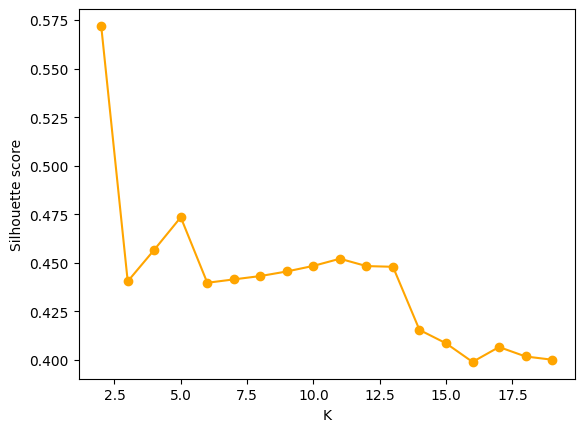

In [14]:
plt.plot(range(2,20), silhouette_score_list,marker='o',color='orange')
plt.xlabel('K')
plt.ylabel('Silhouette score')

Text(0.5, 1.0, 'Elbow')

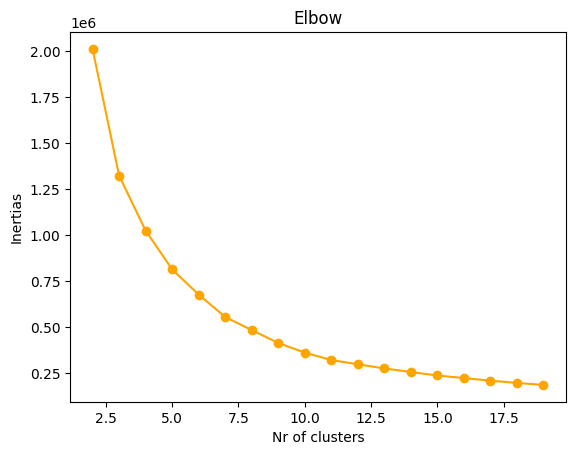

In [16]:
inertias = [model.inertia_ for model in km_list]
plt.plot(range(2,20), inertias,marker='o',color='orange')
plt.xlabel('Nr of clusters')
plt.ylabel('Inertias')
plt.title('Elbow')


(2 clusters)

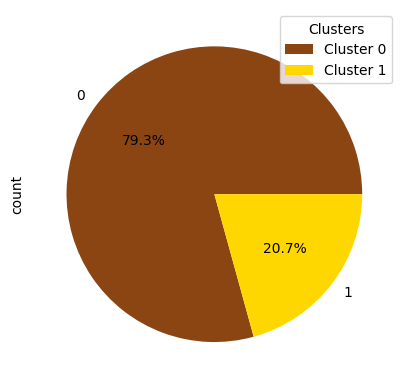

In [19]:
kmeans1 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(X_resampled)

cluster_df = pd.DataFrame(kmeans1.labels_, columns=['Cluster'])

cluster_counts = cluster_df['Cluster'].value_counts()

colors = ['saddlebrown', 'gold']
cluster_counts.plot.pie(autopct="%.1f%%", colors=colors)

plt.legend([f'Cluster {label}' for label in cluster_counts.index], title='Clusters')

In [58]:
# import pickle
# with open('../models/trained_model_clustering.pkl', 'wb') as output:
#     pickle.dump(kmeans1, output)
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'clustering_config.yaml'), 'w') as file:
    yaml.dump(kmeans1.get_params(), file, default_flow_style=False)

(5 clusters)

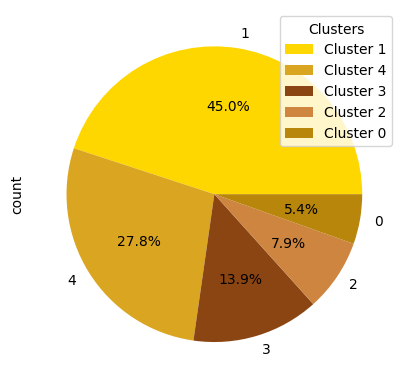

In [22]:
# kmeans2 = KMeans(n_clusters=5, n_init=10, random_state=0).fit(X_resampled)
# pd.DataFrame(kmeans2.labels_,columns=['Cluster']).value_counts().plot.pie(autopct="%.1f%%")
kmeans2 = KMeans(n_clusters=5, n_init=10, random_state=0).fit(X_resampled)

cluster_df = pd.DataFrame(kmeans2.labels_, columns=['Cluster'])

cluster_counts = cluster_df['Cluster'].value_counts()

colors = ['gold','goldenrod','saddlebrown','peru','darkgoldenrod']
cluster_counts.plot.pie(autopct="%.1f%%", colors=colors)

plt.legend([f'Cluster {label}' for label in cluster_counts.index], title='Clusters')

In [31]:
X_resampled['cluster1'] = kmeans1.labels_
X_resampled.groupby('cluster1').mean()

,ABV,IBU,Color,cluster
cluster1,,,,
0,5.779544,27.187710,13.958499,0.927628
1,8.059181,74.346523,21.122096,3.043026


In [32]:
X_resampled['cluster2'] = kmeans2.labels_
X_resampled.groupby('cluster2').mean()

,ABV,IBU,Color,cluster,cluster1
cluster2,,,,,
0,6.262946,31.309199,28.034888,0.0,0.006583
1,5.395810,22.220347,6.074929,1.0,0.000000
2,8.330615,89.798155,12.866011,3.0,1.000000
3,6.896796,52.218992,12.420473,4.0,0.503151
4,8.575130,69.704557,42.843333,2.0,0.992188


In [34]:
X_resampled.drop(columns=['cluster','cluster1','cluster2'],inplace=True)

Clustering didn't work very well let's stick with the gradient boosting classifier.